In [3]:
%pylab nbagg
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import os
import sys

# Set working directory (adjust if needed)
#os.chdir("/Users/giovanni/Documents/GitHub/fufo/notebook/Psychedelic_proj/2025_LisaLuan/notebooks")

sys.path.append(os.path.abspath("../src"))
from functions_figs import *

file_path = '../data/SEEG/df_correlations_5MOIs_ieeg.csv'

Populating the interactive namespace from numpy and matplotlib


/Users/giovanni/anaconda2/envs/p36workshop/lib/python3.6/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/giovanni/anaconda2/envs/p36workshop/lib/python3.6/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Explained_Variance
No. Observations: 7950    Method:             REML              
No. Groups:       36      Scale:              0.0147            
Min. group size:  50      Log-Likelihood:     5399.3907         
Max. group size:  425     Converged:          Yes               
Mean group size:  220.8                                         
-----------------------------------------------------------------
                   Coef.  Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.122     0.012  10.495  0.000   0.099   0.145
Network[T.LIM]     0.013     0.005   2.431  0.015   0.003   0.024
Network[T.CON]     0.028     0.006   4.609  0.000   0.016   0.039
Network[T.DAN]     0.012     0.007   1.871  0.061  -0.001   0.025
Network[T.VAN]     0.014     0.005   2.996  0.003   0.005   0.023
Network[T.SMN]     0.028     0.

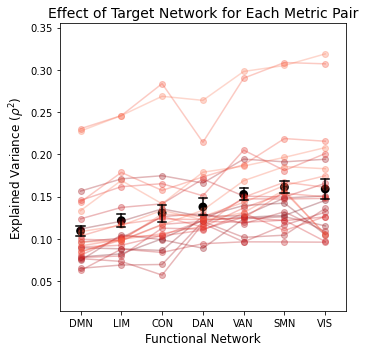

In [6]:
df = pd.read_csv(file_path)

# Define a mapping from M_i to actual metric names
metric_names = {
    "M_13": "Salience",
    "M_14": "Peak Synchrony",
    "M_76": "Entrainment",
    "M_29": "Fluidity",
    "M_119": "Complexity"
}

# Define a mapping for network names (more intuitive acronyms)
network_names = {
    "Default": "DMN",        # Default Mode Network
    "DorsAttn": "DAN",       # Dorsal Attention Network
    "SalVentAttn": "VAN",    # Ventral Attention Network
    "Cont": "CON",           # Control Network
    "Limbic": "LIM",         # Limbic Network
    "SomMot": "SMN",         # Somatomotor Network
    "Vis": "VIS"             # Visual Network
}

# Apply the mapping to replace metric and network codes with names
df["Pre_Metric"] = df["Pre_Metric"].map(metric_names)
df["Post_Metric"] = df["Post_Metric"].map(metric_names)
df["Network"] = df["Network"].map(network_names)

# Define a sorted hierarchy for networks
ordered_networks = ["DMN", "LIM", "CON", "DAN", "VAN", "SMN", "VIS"]

# Ensure categorical ordering of networks
df["Network"] = pd.Categorical(df["Network"], categories=ordered_networks, ordered=True)

# Filter dataset for all pre-post metric pairs at radius = 100
df_filtered = df[df["Radius"] == 100]

# Compute explained variance (rho²) as a single combined measure
df_filtered["Explained_Variance"] = df_filtered["Correlation"]**2

# Fit Linear Mixed-Effects Model (LMEM) considering all metric pairs as a single group
model = smf.mixedlm("Explained_Variance ~ Network", 
                     df_filtered, groups=df_filtered["Patient"], re_formula="~1")
result = model.fit()

# Print LMEM summary
print(result.summary())

# Define colors using the "Spectral_r" palette for each unique Pre/Post pair
unique_pairs = df_filtered.groupby(["Pre_Metric", "Post_Metric"]).size().reset_index()[["Pre_Metric", "Post_Metric"]]
pair_colors = sns.color_palette("Reds_r", n_colors=len(unique_pairs)+20)

# Create a mapping for colors
pair_to_color = {tuple(pair): color for pair, color in zip(unique_pairs.values, pair_colors)}

# Create plot
plt.figure(figsize=(5, 5))

# Loop over each Pre/Post metric pair and plot its mean Explained Variance with confidence intervals
for (pre_metric, post_metric), color in pair_to_color.items():
    subset = df_filtered[(df_filtered["Pre_Metric"] == pre_metric) & (df_filtered["Post_Metric"] == post_metric)]
    
    mean_values = subset.groupby("Network")["Explained_Variance"].mean()
    ci_values = subset.groupby("Network")["Explained_Variance"].std() / np.sqrt(subset.groupby("Network")["Explained_Variance"].count())  # Compute standard error for CI

    plt.plot(ordered_networks, mean_values, marker='o', linestyle='-', alpha=0.3, color=color, label=f"{pre_metric} → {post_metric}")

sns.pointplot(
    x="Network",
    y="Explained_Variance",
    data=df_filtered,
    order=ordered_networks,
    capsize=0.2,  # Confidence interval cap size
    errwidth=1.5,  # Line width of confidence intervals
    join=False,  # Remove line joining points
    color="black"
)

# Labels and title
plt.xlabel("Functional Network", fontsize=12)
plt.ylabel("Explained Variance ($\\rho^2$)", fontsize=12)
plt.title("Effect of Target Network for Each Metric Pair", fontsize=14)
plt.ylim(0.015,0.355)

# Show plot
plt.tight_layout()
#plt.savefig(path_out+'EEG_Network_dependence_sessions.png',dpi=300, transparent=True)

plt.show()